In [39]:
#!/Users/soraward/opt/miniconda3/bin/python3 
data_root = "../data/"
# ML stuff
import numpy as np
from numpy.fft import *
import torch
from sklearn.linear_model import Lasso
import pandas as pd


from PIL import Image
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('image', cmap='gray')

# basic stuff
import datetime
import requests
import io
from collections import Counter


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf




# read data
# for now, reading only unitl ebay
nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
# stock lists
stock_list = ['AMGN','AAPL','MSFT','GOOG','AMZN','FB','TSLA','CTSH','JD','EBAY','AMD','SBUX','NVDA','ZM']
stock_list2 = ['CHKP','CHTR','CMCSA','COST','CPRT','CRWD','CSCO','CSX','CTAS','CTSH','DLTR','DOCU','DXCM','EA']
stock_list3 = ['EXC','FAST','FB','FISV','FOX','FOXA','GILD','GOOG','GOOGL','HON','IDXX','ILMN','INCY','INTC','INTU']
first_names = list(set([name for name in nasdaq.Name]))

using = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "FB", "NVDA"]#, "TSM", "UNH", "V"]

In [15]:
# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    return nasdaq_c

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL"):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    new_nasdaq.dropna(inplace=True)
    return new_nasdaq

# create features volatility, volume, adj close
def get_features(nasdaq):
    #rename Adj Close
    nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True)
    nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
    nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
    nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
    nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    return nasdaq

def get_stock(nasdaq, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, feature="log_Adj_Close", using=using):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

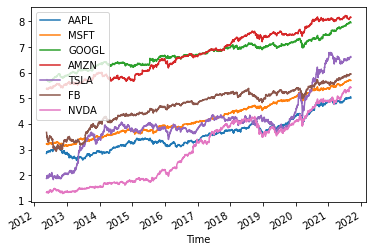

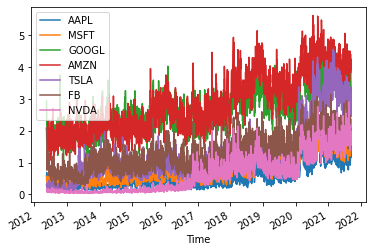

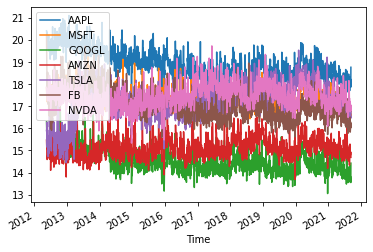

In [25]:
plot_attribute(nasdaq, "log_Adj_Close")
plot_attribute(nasdaq, "log_Volatility")
plot_attribute(nasdaq, "log_Volume")

In [42]:
def filter_signal(signal, threshhold=1e8):
    fourier = rfft(get_stock(nasdaq).log_Volume)
    freqs = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[freqs > threshhold] = 0
    return irfft(fourier)

In [52]:
get_stock(nasdaq).log_Volume.reset_index().drop("Time", axis=1)

,log_Volume
0,20.017499
1,20.215610
2,20.129348
3,19.983302
4,19.919435
...,...
2938,17.872650
2939,18.225618
2940,18.125238
2941,17.863911


In [68]:
def plot_filtered(nasdaq, stock_name="AAPL",stock_feature="log_Volume", threshhold=2e3):
    stock_signal = get_stock(nasdaq, stock_name)[stock_feature]
    stock_signal = stock_signal.reset_index().drop("Time", axis=1)
    filtered = filter_signal(stock_signal, threshhold)

    plt.figure(figsize=(20, 10))
    plt.plot(stock_signal, label="Raw")
    plt.plot(filtered, label="Filtered")
    plt.legend()
    plt.show()

In [59]:
stock_signal.shape, filtered.shape

((2943,), (2942,))

In [58]:
stock_signal = get_stock(nasdaq)["log_Volume"]
filtered = filter_signal(stock_signal)
filtered_series = pd.Series(filtered, index=stock_signal.index)


ValueError: Length of values (2942) does not match length of index (2943)

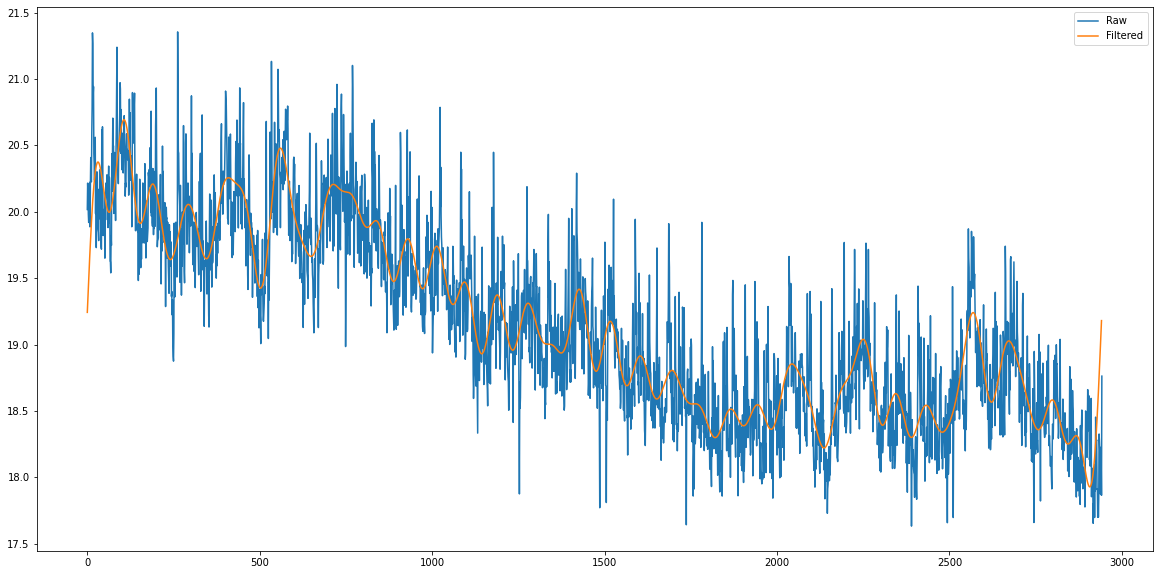

In [69]:
plot_filtered(nasdaq)

In [31]:
get_stock(nasdaq, "AMZN").isna().sum()


Adj_Close         0
log_Volatility    0
log_Volume        0
log_Adj_Close     0
dtype: int64

In [28]:
# ends = {name:get_stock(nasdaq, name)["Adj Close"][-1] for name in first_names}
# ends_sorted = dict(sorted(ends.items(), key=lambda item: item[1], reverse=True))

# top 10 stocks by the end of dataset
using = ['AMZN','GOOG','GOOGL','BKNG','MELI','ISRG','ASML','CHTR','TSLA','ALGN']